In [1]:
# !pip install seaborn
# !pip install scipy
# !pip install geopandas
# !pip install imageio

import pandas as pd
import pickle
import json
import requests
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
from scipy import signal
from datetime import date,timedelta
import yaml
import os
import copy
import numpy as np
from itertools import zip_longest
import geopandas as gpd
from shapely.geometry import Polygon
import imageio

from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

cmap = plt.cm.YlOrRd.copy()
cmap.set_bad('lightgrey',1.)

/tmp/ipykernel_746522/3909578464.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# shell download and unzip
!rm -rf cb_2018_us_state_500k
!curl https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip > ./cb_2018_us_state_500k.zip
!mkdir cb_2018_us_state_500k && cd cb_2018_us_state_500k && unzip ../cb_2018_us_state_500k.zip

gdf0 = gpd.read_file('./cb_2018_us_state_500k')
territories = ['MP','VI','GU','AS','PR','DC']
gdf0 = gdf0[~gdf0.STUSPS.isin(territories)]
states = gdf0.STUSPS

state_to_abbrev_d = {"Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY", "District of Columbia": "DC", "American Samoa": "AS", "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR", "United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI"}
def state_to_abbrev(x):
    return state_to_abbrev_d[x] if x in state_to_abbrev_d else '??'

def USmap(data, scalarcmap=None):
    if scalarcmap is None:
        scalarcmap = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.LogNorm(vmin=1e-2, vmax=10, clip=True))
    gdf = gdf0.merge(data.rename('data'), on='STUSPS', how='left').fillna(0.)
    gdf['value_determined_color'] = gdf['data'].apply(lambda x: mcolors.to_hex(scalarcmap.to_rgba(x)))
    # equal area projection for USA
    visframe = gdf.to_crs({'init':'epsg:2163'})

    fig, ax = plt.subplots(1, figsize=(18, 14))
    # remove the axis box around the vis
    ax.axis('off')
    for i, row in visframe.iterrows():
        if row['STUSPS'] not in ['AK','HI']:
            vf = visframe[visframe['STUSPS']==row['STUSPS']]
            c = gdf[gdf['STUSPS']==row['STUSPS']][0:1].value_determined_color.item()
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

    # add Alaska
    akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
    akax.axis('off')
    # polygon to clip western islands
    polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
    alaska_gdf = gdf[gdf['STUSPS']=='AK']
    alaska_gdf.clip(polygon).plot(color=gdf[gdf['STUSPS']=='AK'].value_determined_color.item(), linewidth=0.8,ax=akax, edgecolor='0.8')

    # add Hawaii
    hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
    hiax.axis('off')
    # polygon to clip western islands
    hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
    hawaii_gdf = gdf[gdf['STUSPS']=='HI']
    hawaii_gdf.clip(hipolygon).plot(color=hawaii_gdf['value_determined_color'].item(), linewidth=0.8,ax=hiax, edgecolor='0.8')

    return fig, ax

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3227k    0 3227k    0     0  4009k      0 --:--:-- --:--:-- --:--:-- 4009k
Archive:  ../cb_2018_us_state_500k.zip
  inflating: cb_2018_us_state_500k.shp.ea.iso.xml  
  inflating: cb_2018_us_state_500k.shp.iso.xml  
  inflating: cb_2018_us_state_500k.shp  
  inflating: cb_2018_us_state_500k.shx  
  inflating: cb_2018_us_state_500k.dbf  
  inflating: cb_2018_us_state_500k.prj  
 extracting: cb_2018_us_state_500k.cpg  


In [3]:
from outbreak_data.authenticate_user import set_authentication
from outbreak_data import outbreak_data
import auth_token

#### authenticate

In [4]:
set_authentication(auth_token.get_auth_token())

#### number of sites having recorded at least one sample containing BA.2.86 or a descendant over time

In [5]:
ba286_samples = outbreak_data.get_wastewater_samples_by_lineage('BA.2.86', descendants=True)
ba286_samples = outbreak_data.get_wastewater_metadata(ba286_samples)

https://dev.outbreak.info/wastewater_demix/query?fetch_all=true&fields=sra_accession&q=crumbs:*;BA.2.86;*
https://dev.outbreak.info/wastewater_demix/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAAA9gUxZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=0
https://dev.outbreak.info/wastewater_demix/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAAA9gUxZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=1
https://dev.outbreak.info/wastewater_demix/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAAA9gUxZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=2
https://dev.outbreak.info/wastewater_demix/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAAA9gUxZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=3
https://dev.outbreak.info/wastewater_demix/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWl

<Axes: xlabel='collection_date'>

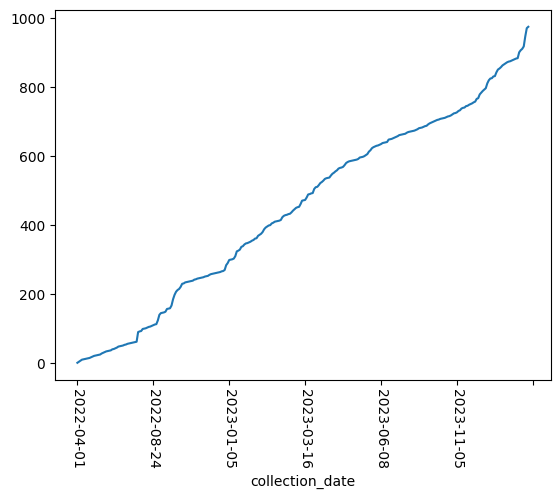

In [6]:
ba286_sites = ba286_samples.groupby('collection_site_id')['collection_date'].min()
ba286_sites = ba286_sites.groupby(ba286_sites).agg(len).sort_index().cumsum()
ba286_sites.plot(rot=-90)

#### map of date of third sample to contain BA.2.86 or a descendant

STUSPS
??    2022-05-13
AK    2023-12-13
AL    2022-09-20
AR    2023-01-24
AZ    2022-07-25
CA    2023-02-07
CO    2022-04-04
CT    2023-02-22
DC    2023-12-27
FL    2022-04-13
GA    2023-12-03
GU    2023-02-08
HI    2023-12-12
IA    2023-03-09
ID    2024-02-28
IL    2023-03-07
IN    2023-02-14
KS    2023-03-27
KY    2023-12-20
LA    2023-02-20
MA    2023-06-07
MD    2023-03-13
ME    2023-08-22
MI    2023-08-31
MN    2023-07-24
MO    2022-08-25
MS    2022-10-25
MT    2023-06-05
NC    2022-05-16
NE    2023-12-20
NH    2023-05-22
NJ    2023-02-15
NM    2022-09-07
NV    2022-04-01
NY    2022-09-12
OH    2023-04-23
OK    2023-04-03
OR    2023-04-10
PA    2023-02-21
PR    2023-03-21
SC    2024-02-26
SD    2023-03-27
TN    2023-04-17
TX    2022-08-01
UT    2022-04-19
VA    2023-06-27
VT    2023-05-17
WA    2022-08-29
WV    2023-11-08
WY    2023-06-27
Name: collection_date, dtype: object


/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


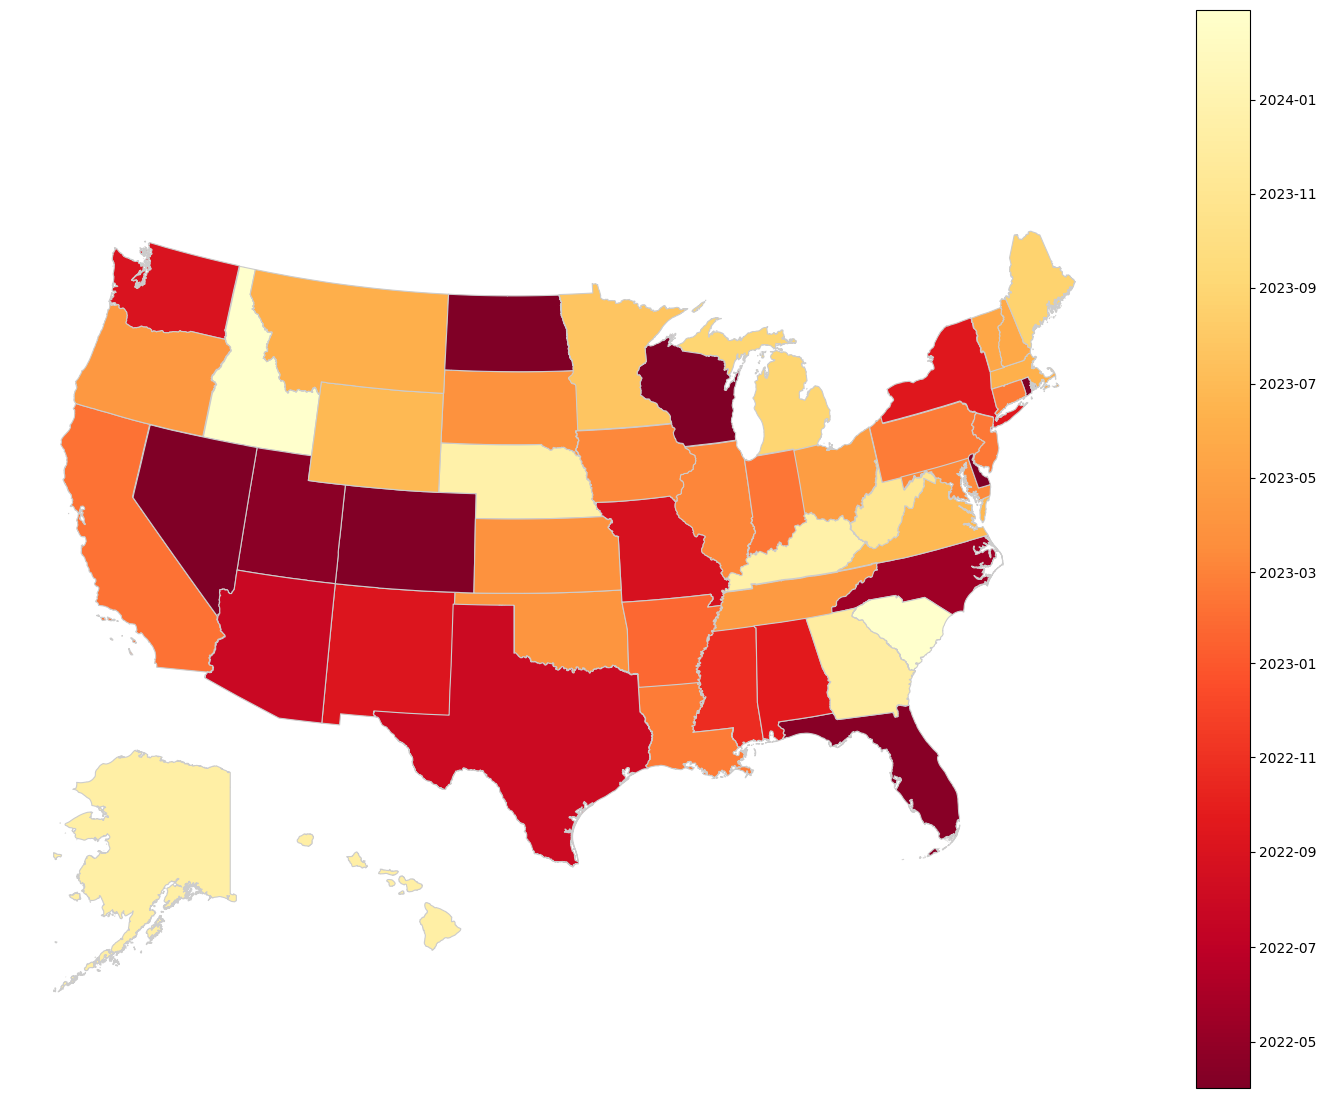

In [7]:
ba286_samples['STUSPS'] = ba286_samples['geo_loc_region'].apply(state_to_abbrev)
date_third_sample = ba286_samples.groupby('STUSPS')['collection_date'].apply(lambda x: list(x.sort_values())[:3][-1])
print(date_third_sample)

date_third_sample = pd.to_datetime(date_third_sample).apply(matplotlib.dates.date2num)
datecolors = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=mcolors.Normalize(vmin=date_third_sample.min(), vmax=date_third_sample.max(), clip=True))
fig, ax = USmap(date_third_sample, datecolors)
loc = matplotlib.dates.AutoDateLocator()
fig.colorbar(datecolors, ax=ax, ticks=loc, format=matplotlib.dates.AutoDateFormatter(loc))

#### number of collection sites having recorded at least one sample containing a G at bp site 1003 over time

In [8]:
g1003_samples = outbreak_data.get_wastewater_samples_by_mutation(site=1003, alt_base='G')
g1003_samples = outbreak_data.get_wastewater_metadata(g1003_samples)

https://dev.outbreak.info/wastewater_variants/query?fetch_all=true&fields=sra_accession&q=site:1003 AND alt_base:G
https://dev.outbreak.info/wastewater_variants/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAAA-CeRZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=0


<Axes: xlabel='collection_date'>

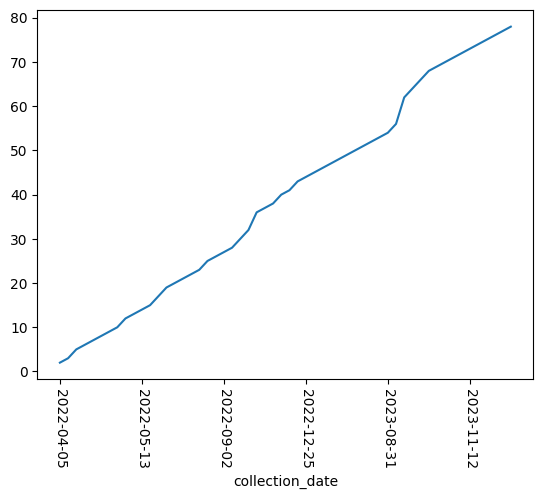

In [9]:
g1003_sites = g1003_samples.groupby('collection_site_id')['collection_date'].min()
g1003_sites = g1003_sites.groupby(g1003_sites).agg(len).sort_index().cumsum()
g1003_sites.plot(rot=-90)

#### map of percentage of samples containing a G at bp site 1003 in sept-dec 2023

In [10]:
startdate, enddate = "2023-09-01", "2023-12-31"
usa_samples = outbreak_data.get_wastewater_samples(country='USA', date_range=[startdate, enddate])

https://dev.outbreak.info/wastewater_metadata/query?fetch_all=true&q=geo_loc_country:USA AND collection_date:[2023-09-01 TO 2023-12-31] AND demix_success:true
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAAA-E9hZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=0
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAAA-E9hZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=1
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAAA-E9hZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=2
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAAA-E9hZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=3
https://dev.outbreak.

/tmp/ipykernel_746522/1752258278.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  g1003_percent = g1003_percent['has_g1003'].fillna(False).groupby(g1003_percent['geo_loc_region'].apply(state_to_abbrev).rename('STUSPS'))
/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


STUSPS
AK    0.000000
AL    0.000000
AR    0.014925
CA    0.003378
CO    0.000000
CT    0.000000
DC    0.000000
FL    0.000000
GA    0.000000
GU    0.000000
HI    0.000000
IA    0.000000
ID    0.000000
IL    0.000000
IN    0.023256
KS    0.051724
KY    0.000000
LA    0.000000
MA    0.022727
MD    0.000000
ME    0.011111
MI    0.000000
MN    0.000000
MO    0.000000
MS    0.000000
MT    0.000000
NC    0.000000
ND    0.000000
NE    0.000000
NH    0.066667
NJ    0.000000
NM    0.066667
NV    0.000000
NY    0.000000
OH    0.000912
OK    0.000000
OR    0.000000
PA    0.004902
RI    0.000000
SC    0.000000
SD    0.000000
TN    0.000000
TX    0.031579
UT    0.000000
VA    0.000000
VT    0.000000
WA    0.330303
WI    0.000000
WV    0.000000
WY    0.000000
Name: has_g1003, dtype: float64


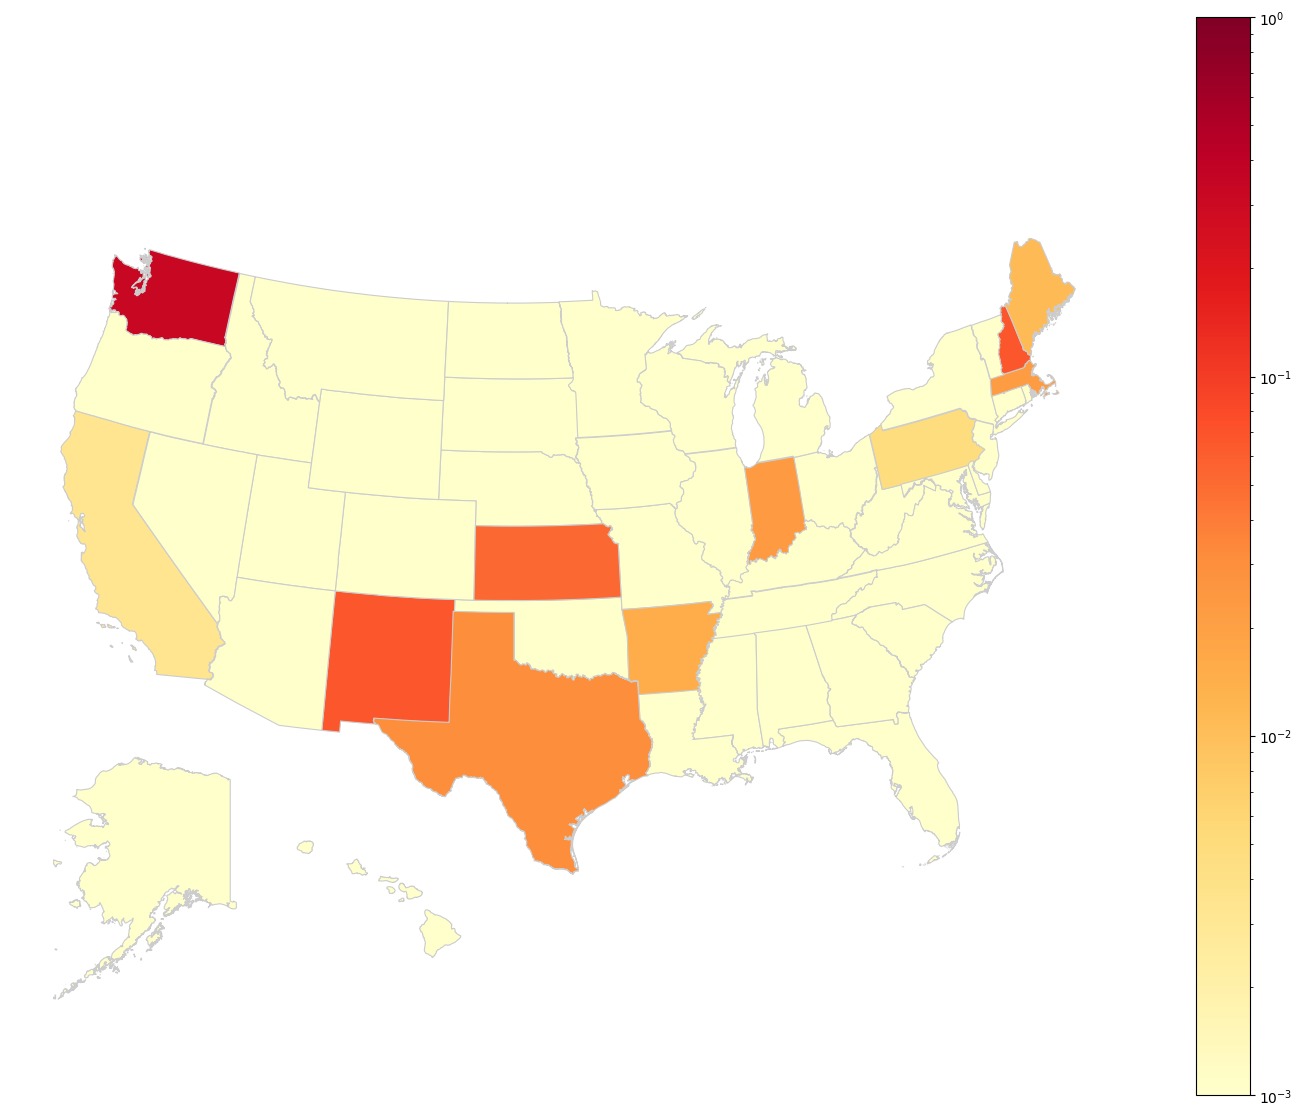

In [11]:
g1003_samples = g1003_samples[(g1003_samples['collection_date'] >= startdate) & (g1003_samples['collection_date'] <= enddate)]
g1003_samples['has_g1003'] = True
g1003_percent = g1003_samples.set_index('sra_accession')['has_g1003'].to_frame().join(usa_samples.set_index('sra_accession')['geo_loc_region'], how='right')
g1003_percent = g1003_percent['has_g1003'].fillna(False).groupby(g1003_percent['geo_loc_region'].apply(state_to_abbrev).rename('STUSPS'))
g1003_percent = g1003_percent.apply(lambda x: x.sum() / len(x))
print(g1003_percent)

colors = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.LogNorm(vmin=1e-3, vmax=1, clip=True))
fig, ax = USmap(g1003_percent, colors)
fig.colorbar(colors, ax=ax)

#### animated weekly map of HV.1* abundance across US states

In [12]:
usa_samples = outbreak_data.get_wastewater_lineages(usa_samples)

In [13]:
ww_abd = outbreak_data.normalize_viral_loads_by_site(usa_samples).groupby('geo_loc_region') \
            .apply(lambda x: outbreak_data.datebin_and_agg(x.copy(), startdate=startdate, enddate=enddate, freq='7D', loaded=True))
for column in ww_abd.columns:
    if column != 'viral_load':
        ww_abd[column] = ww_abd[column].fillna(0)

/tmp/ipykernel_746522/3865152847.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: outbreak_data.datebin_and_agg(x.copy(), startdate=startdate, enddate=enddate, freq='7D', loaded=True))


In [14]:
tree, lineage_key = outbreak_data.get_tree()

In [15]:
lin = 'HV.1'
data = ww_abd.apply(lambda x: outbreak_data.get_agg_abundance(lineage_key[lin], x), axis=1).rename('abundance').to_frame().reset_index()

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


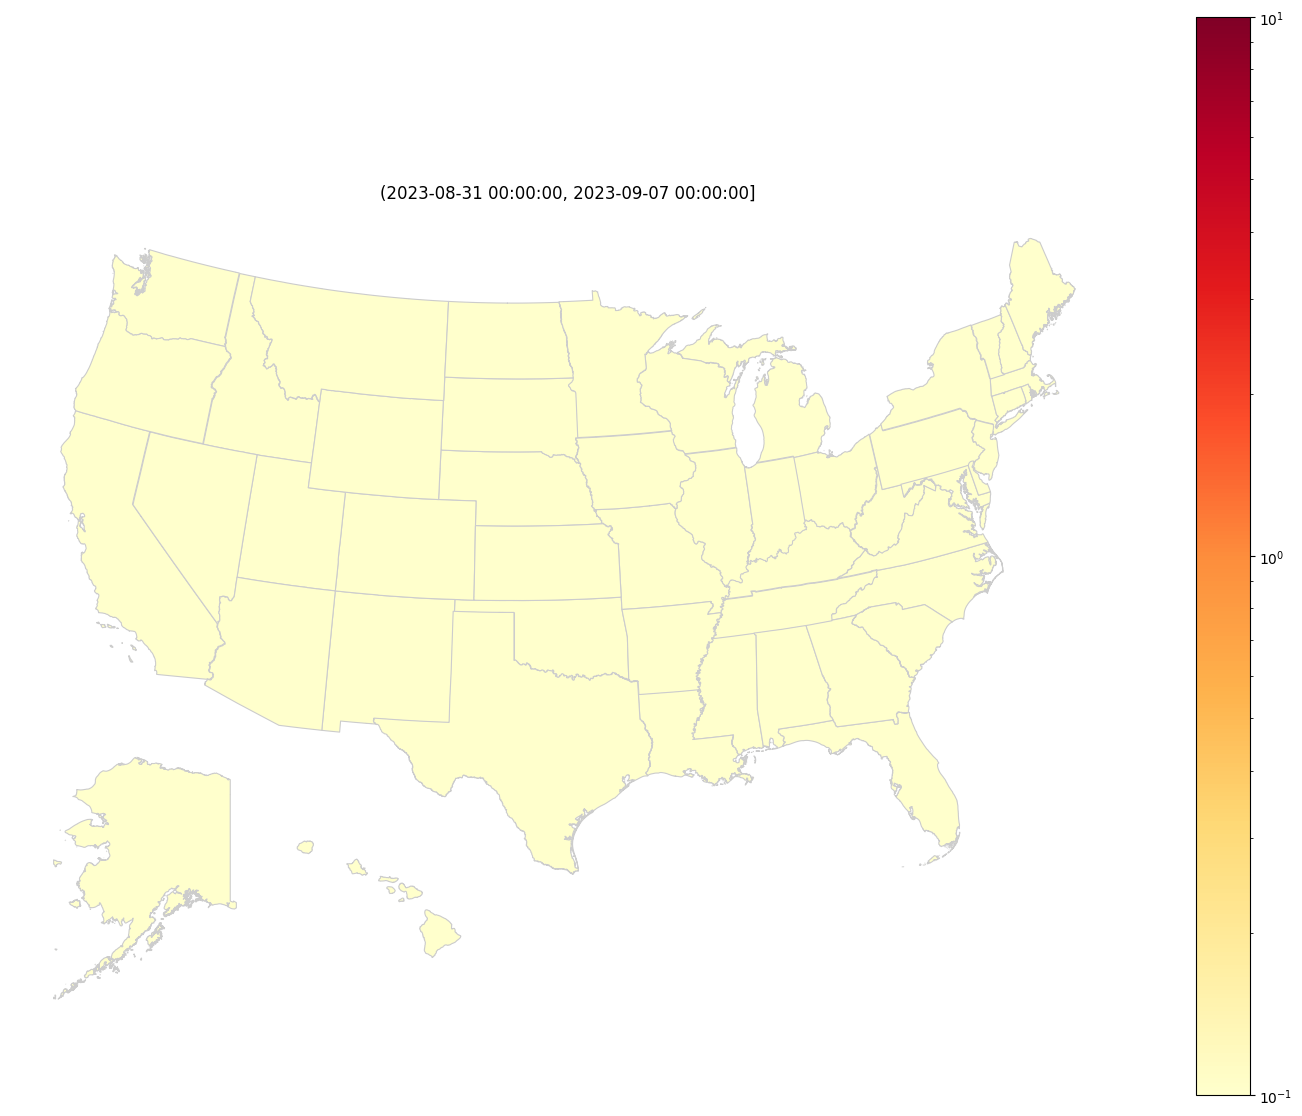

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


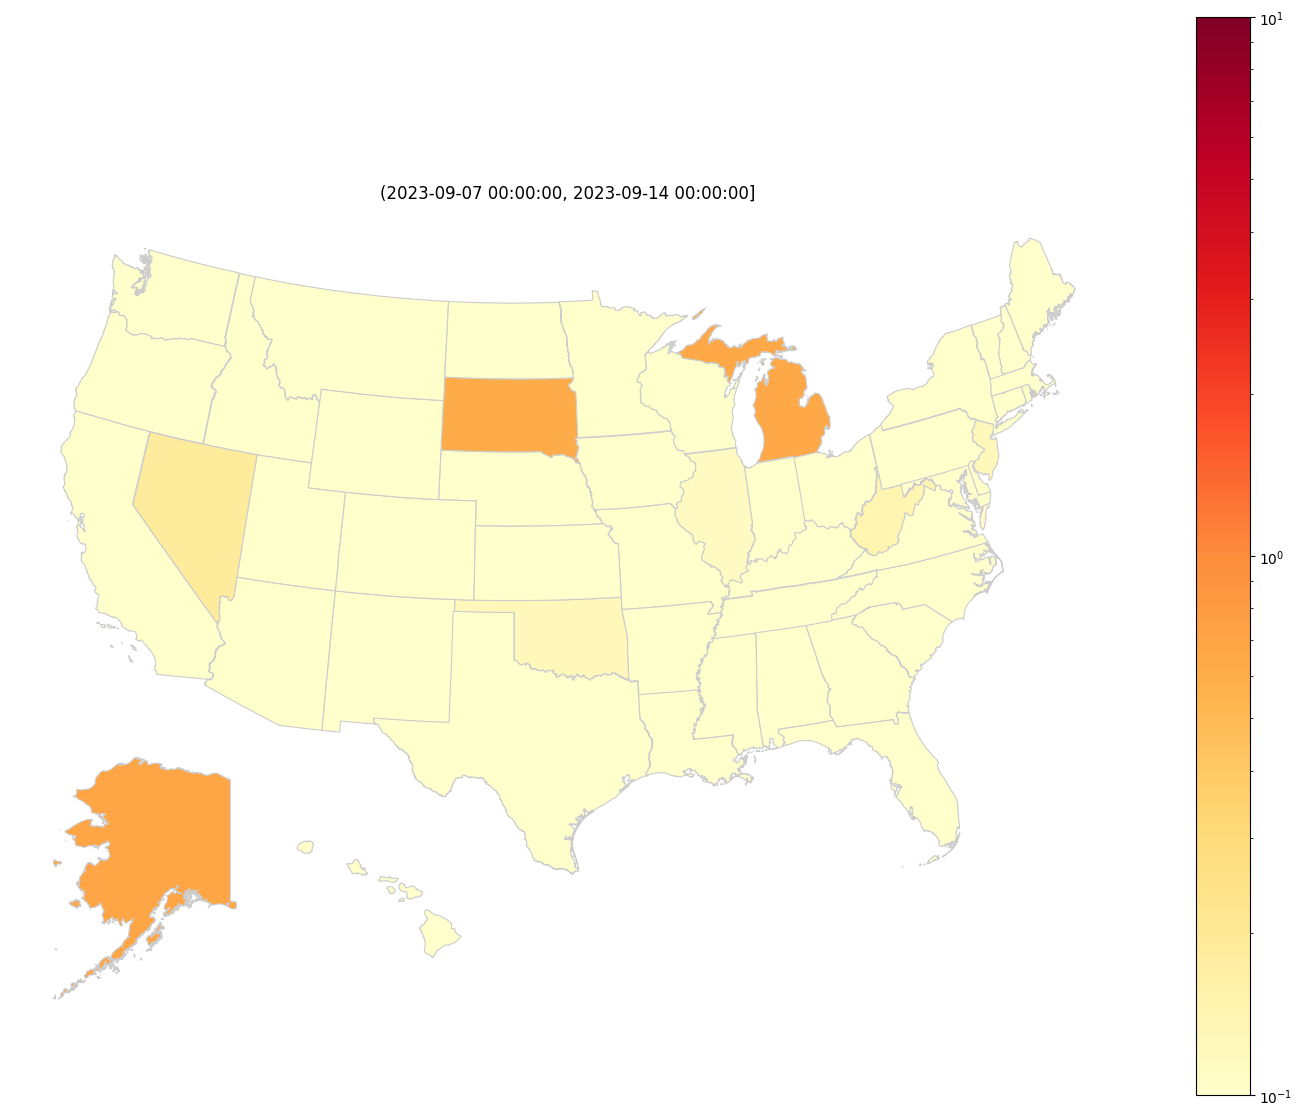

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


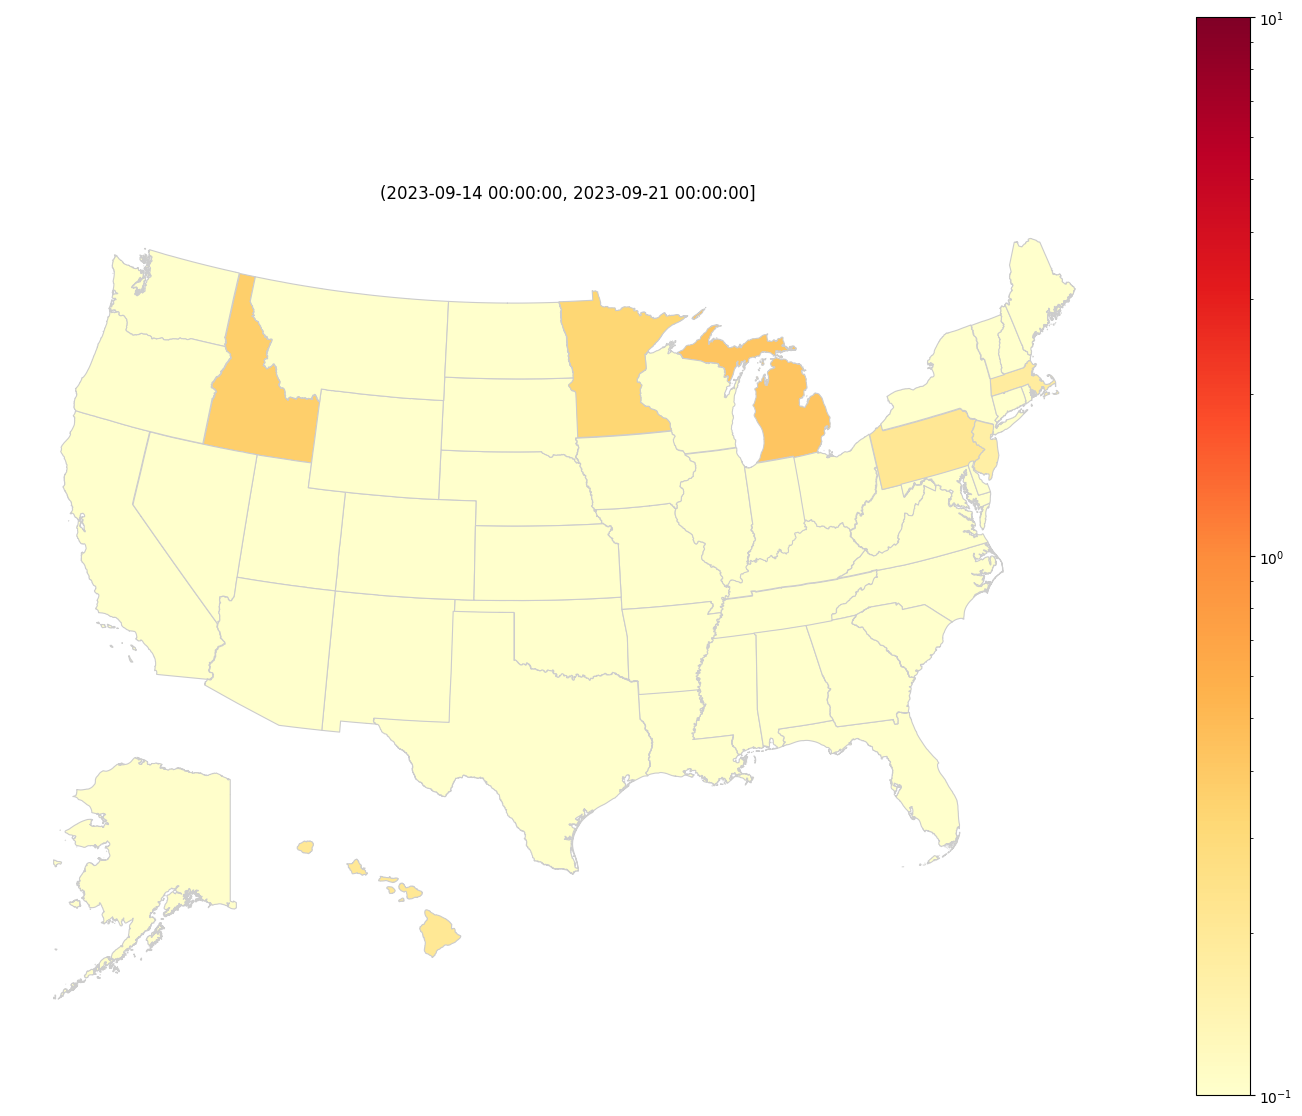

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


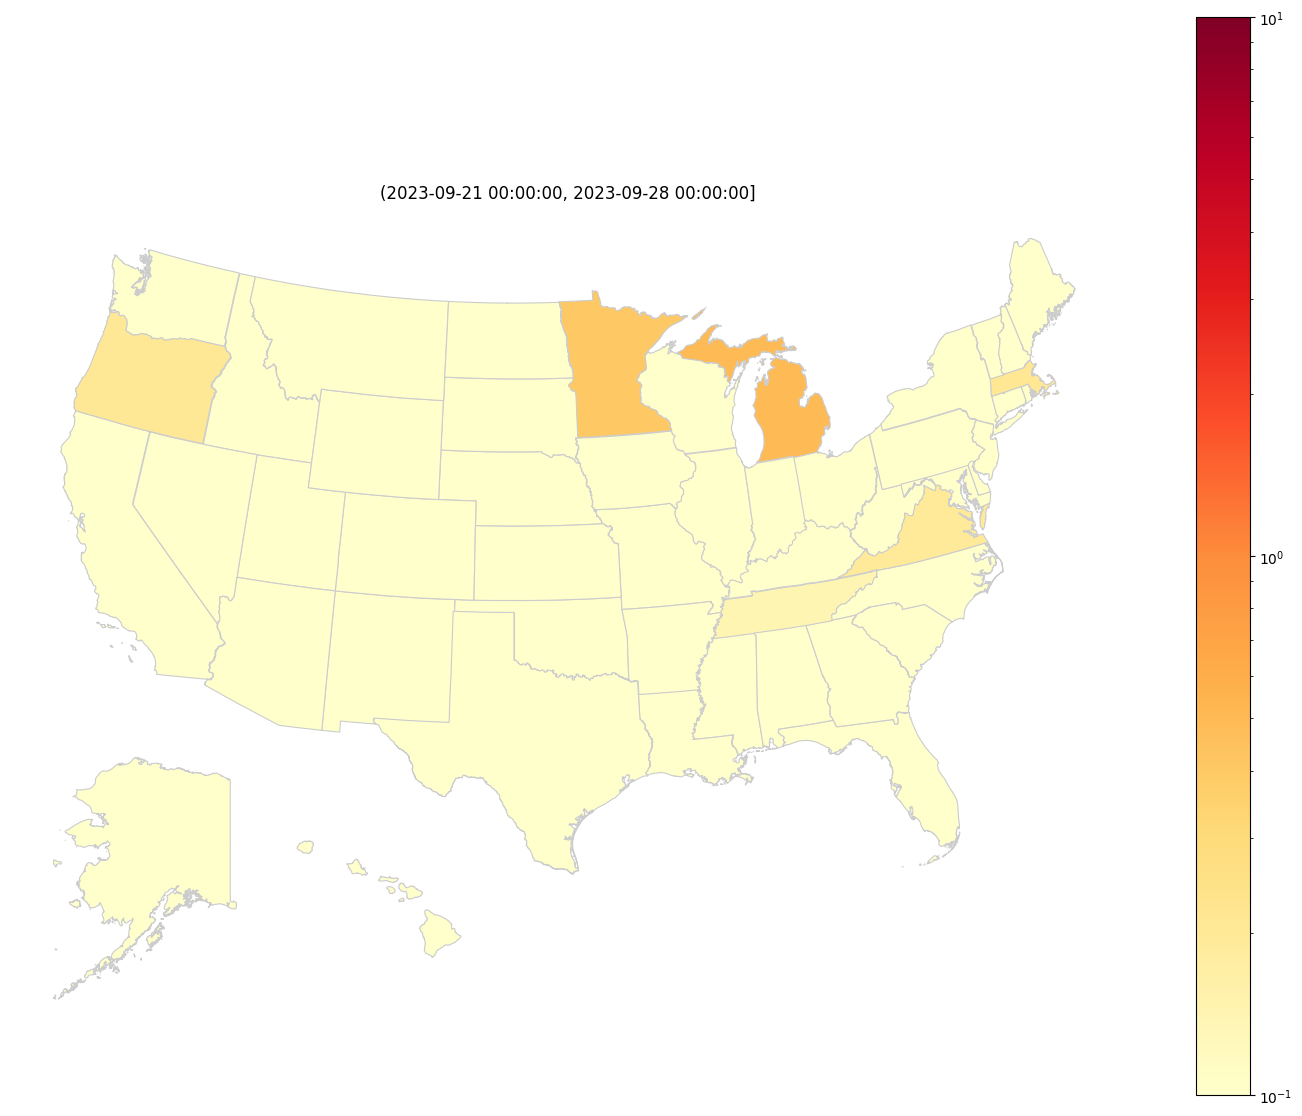

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


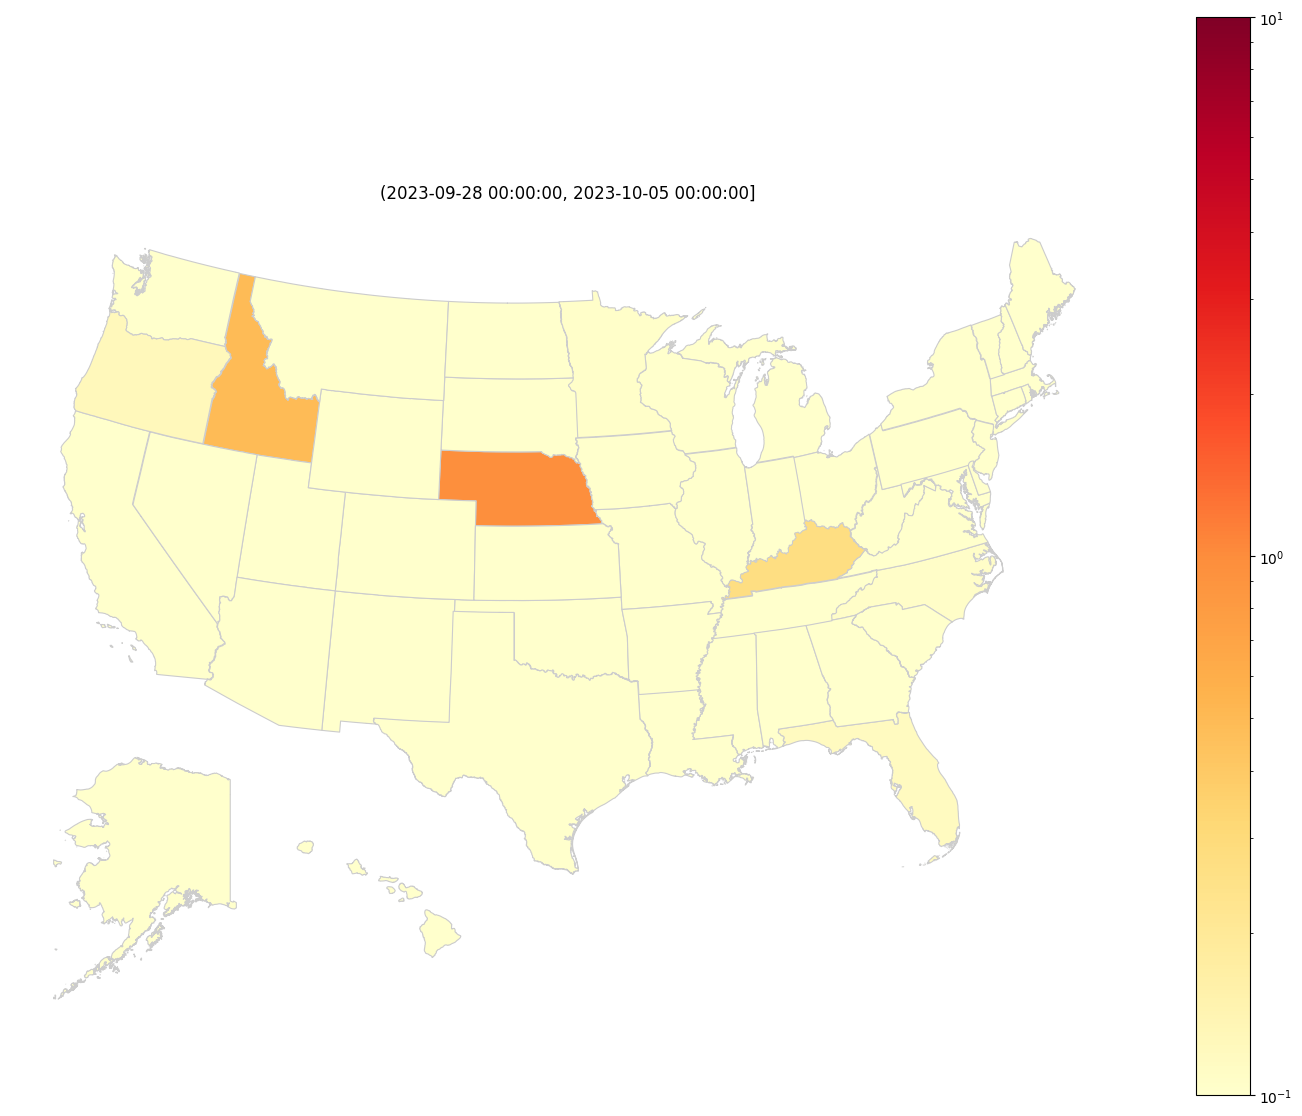

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


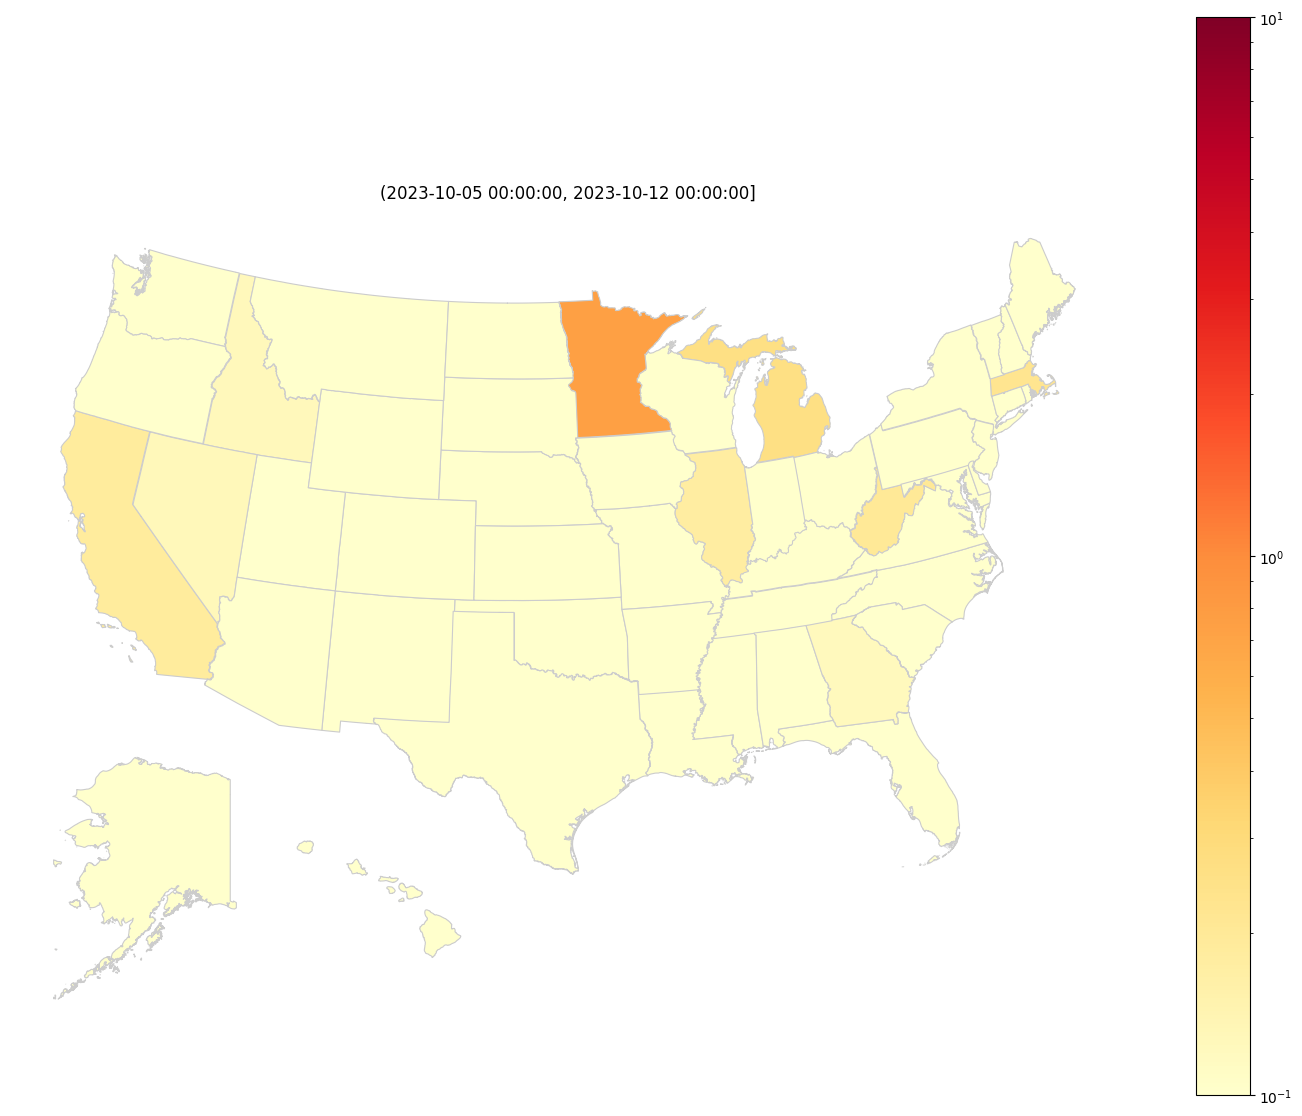

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


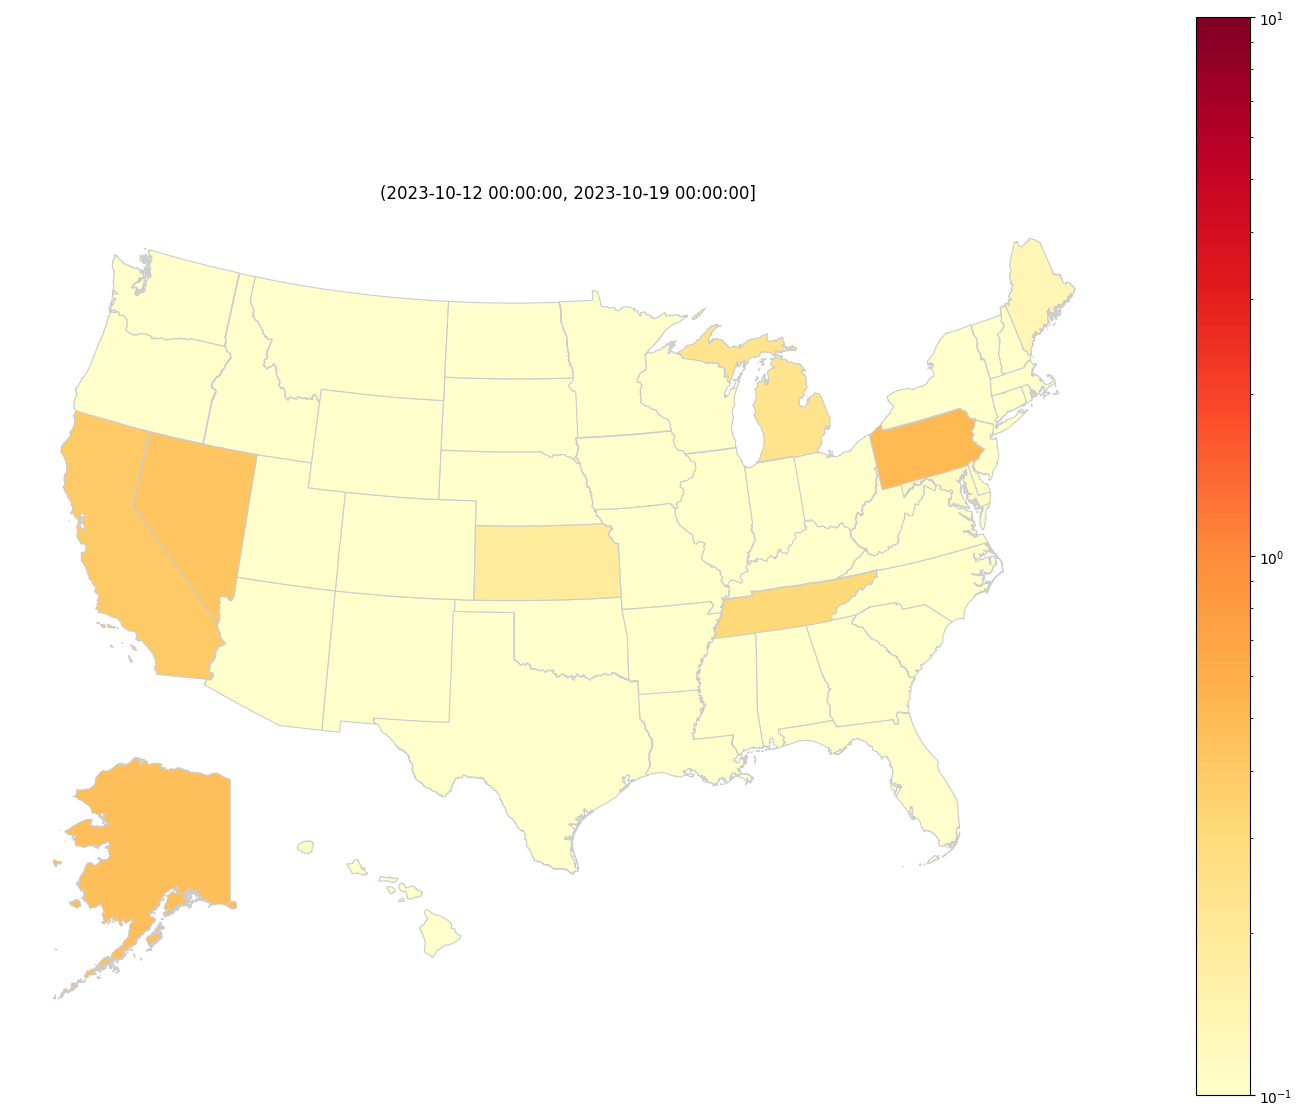

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


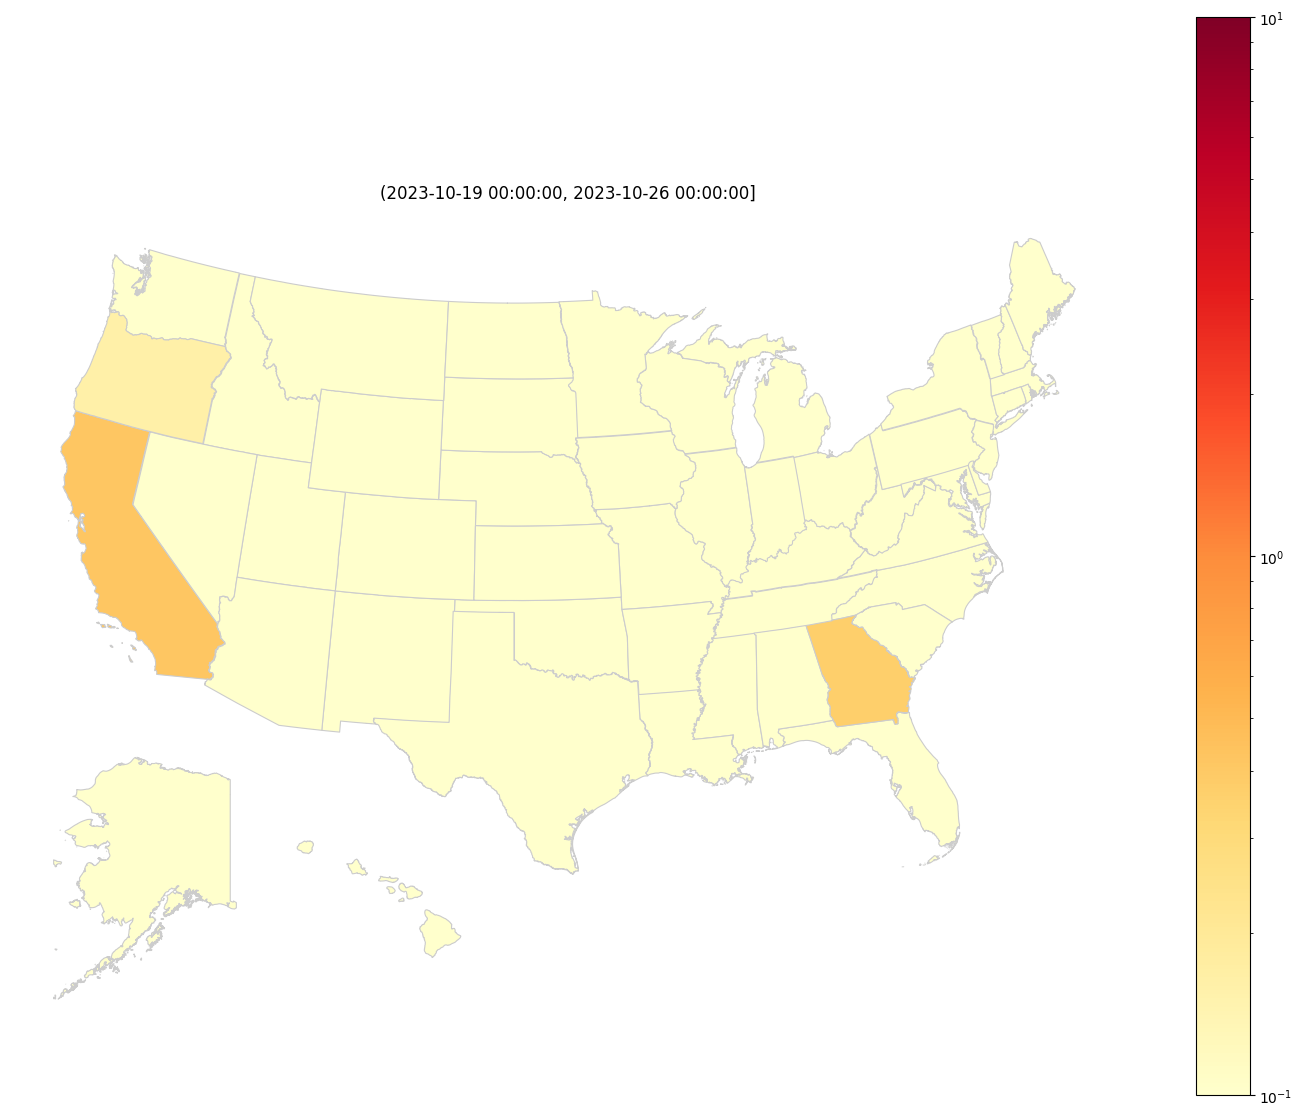

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


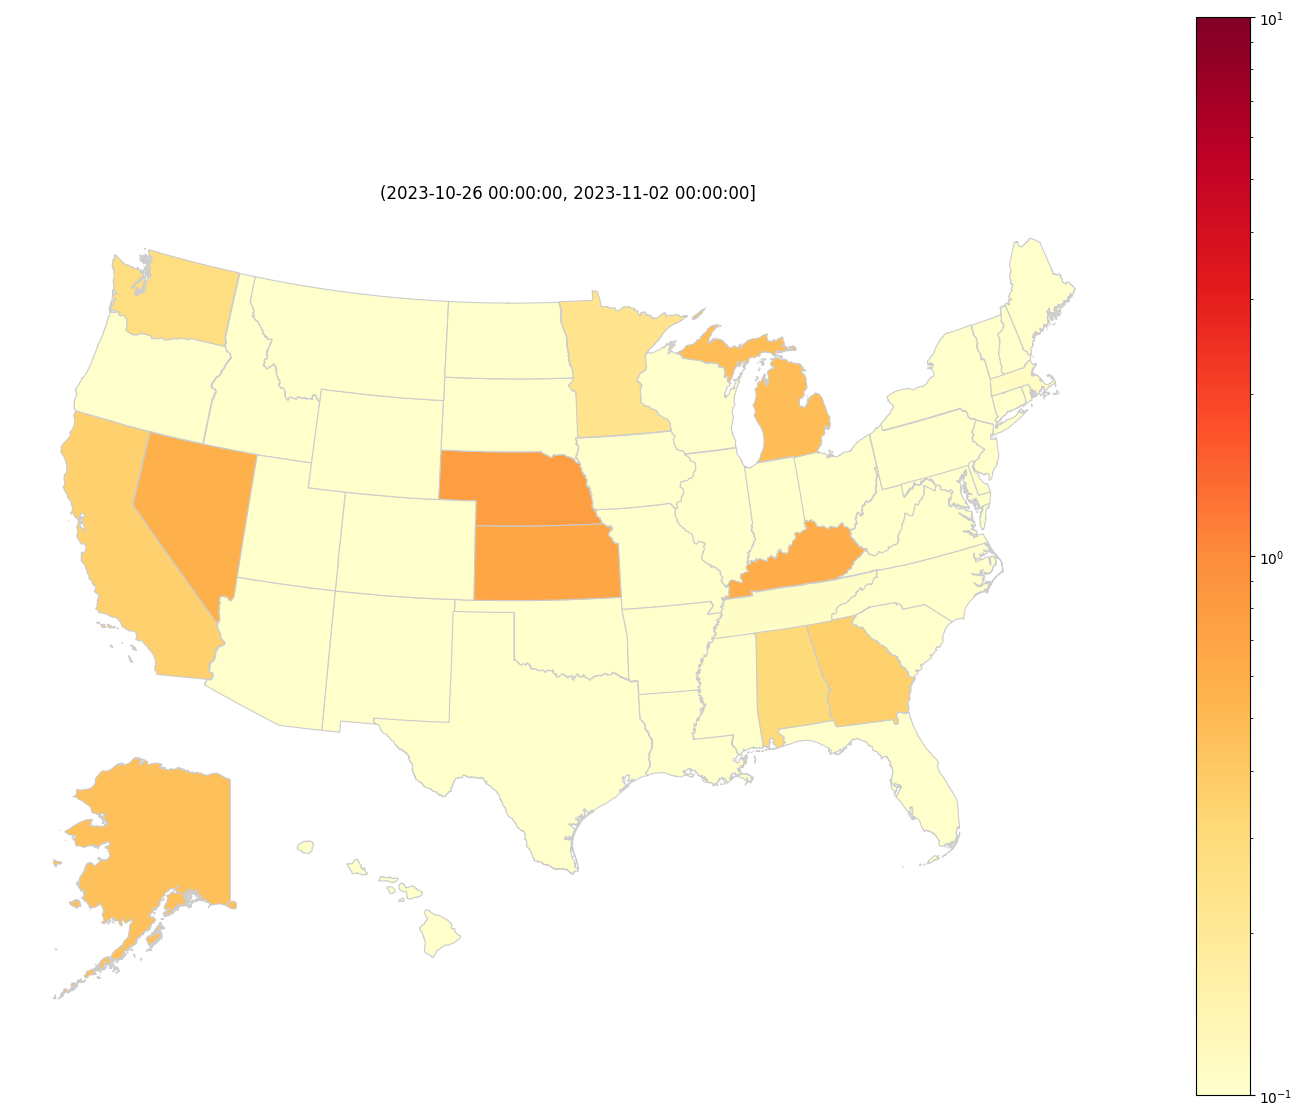

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


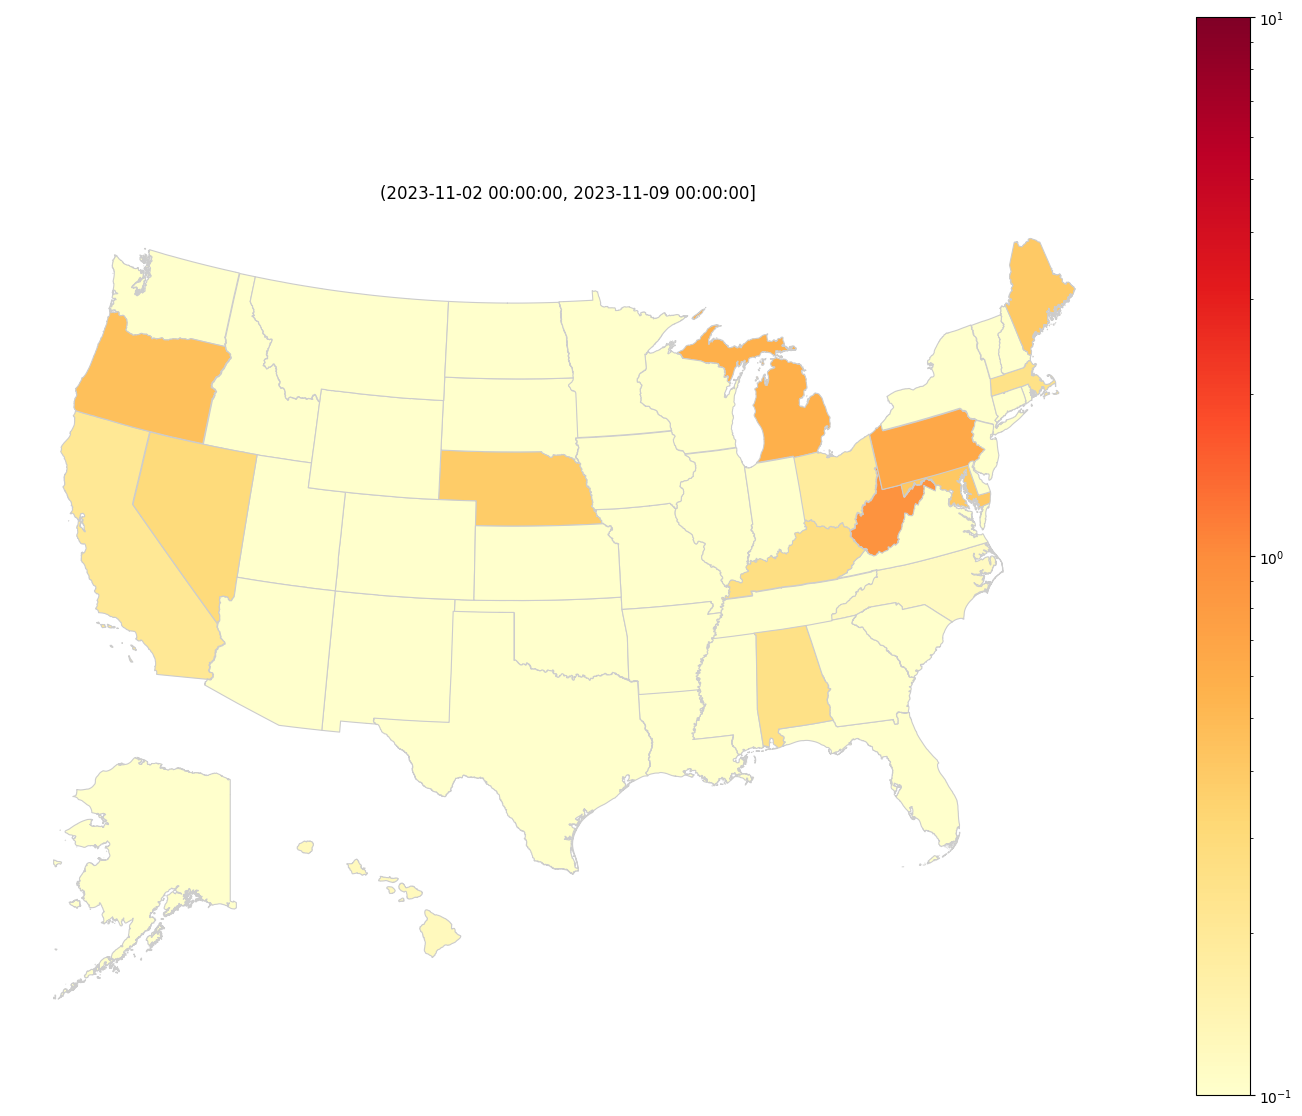

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


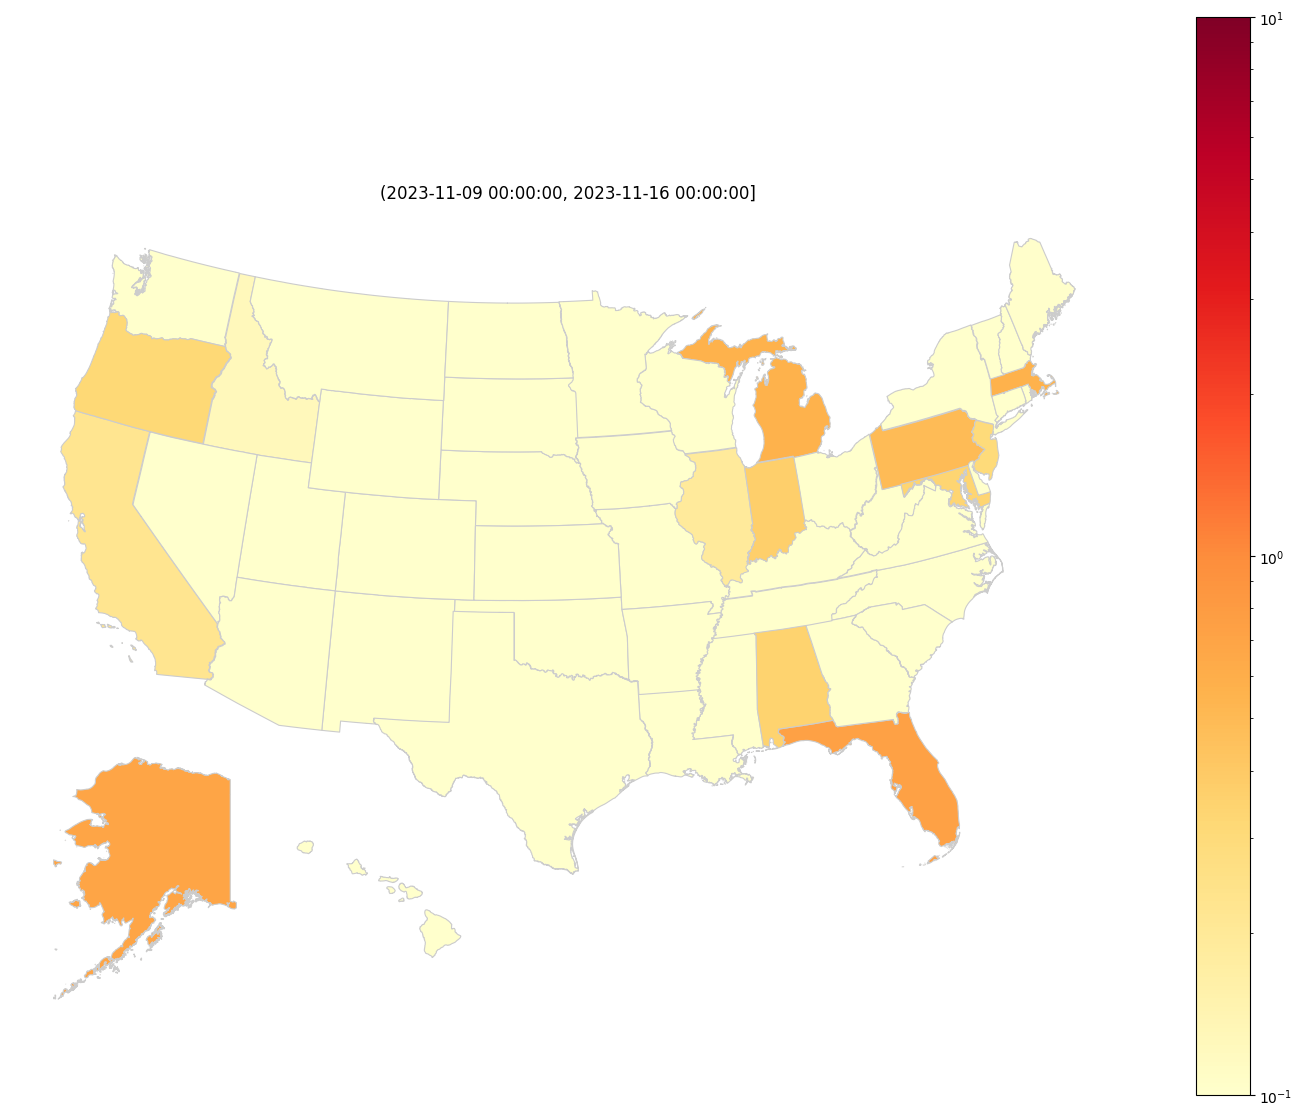

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


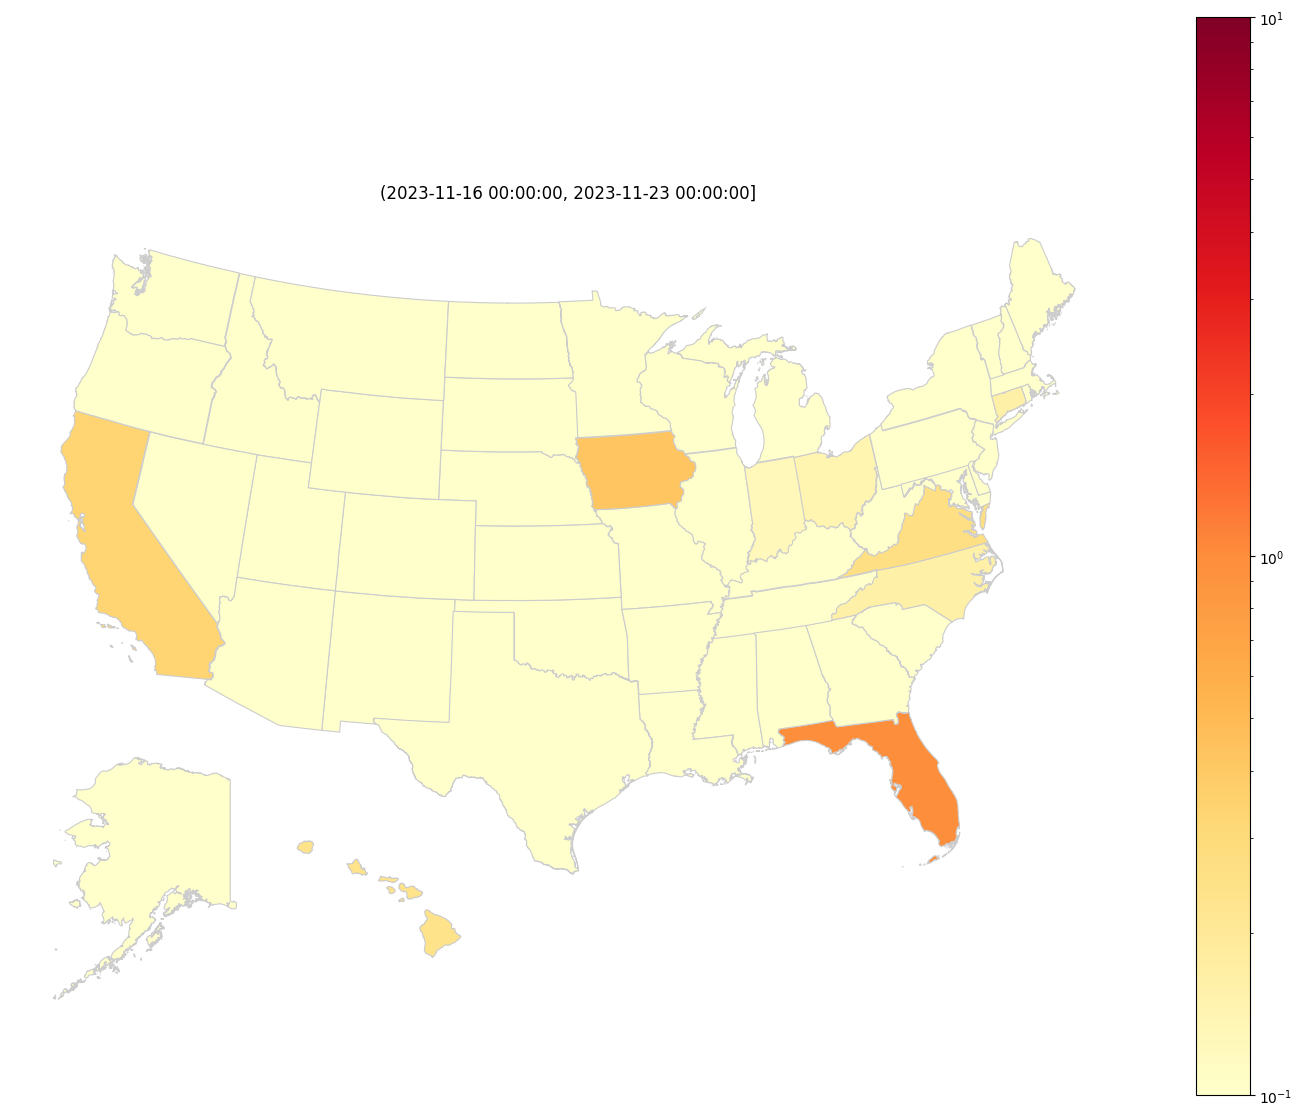

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


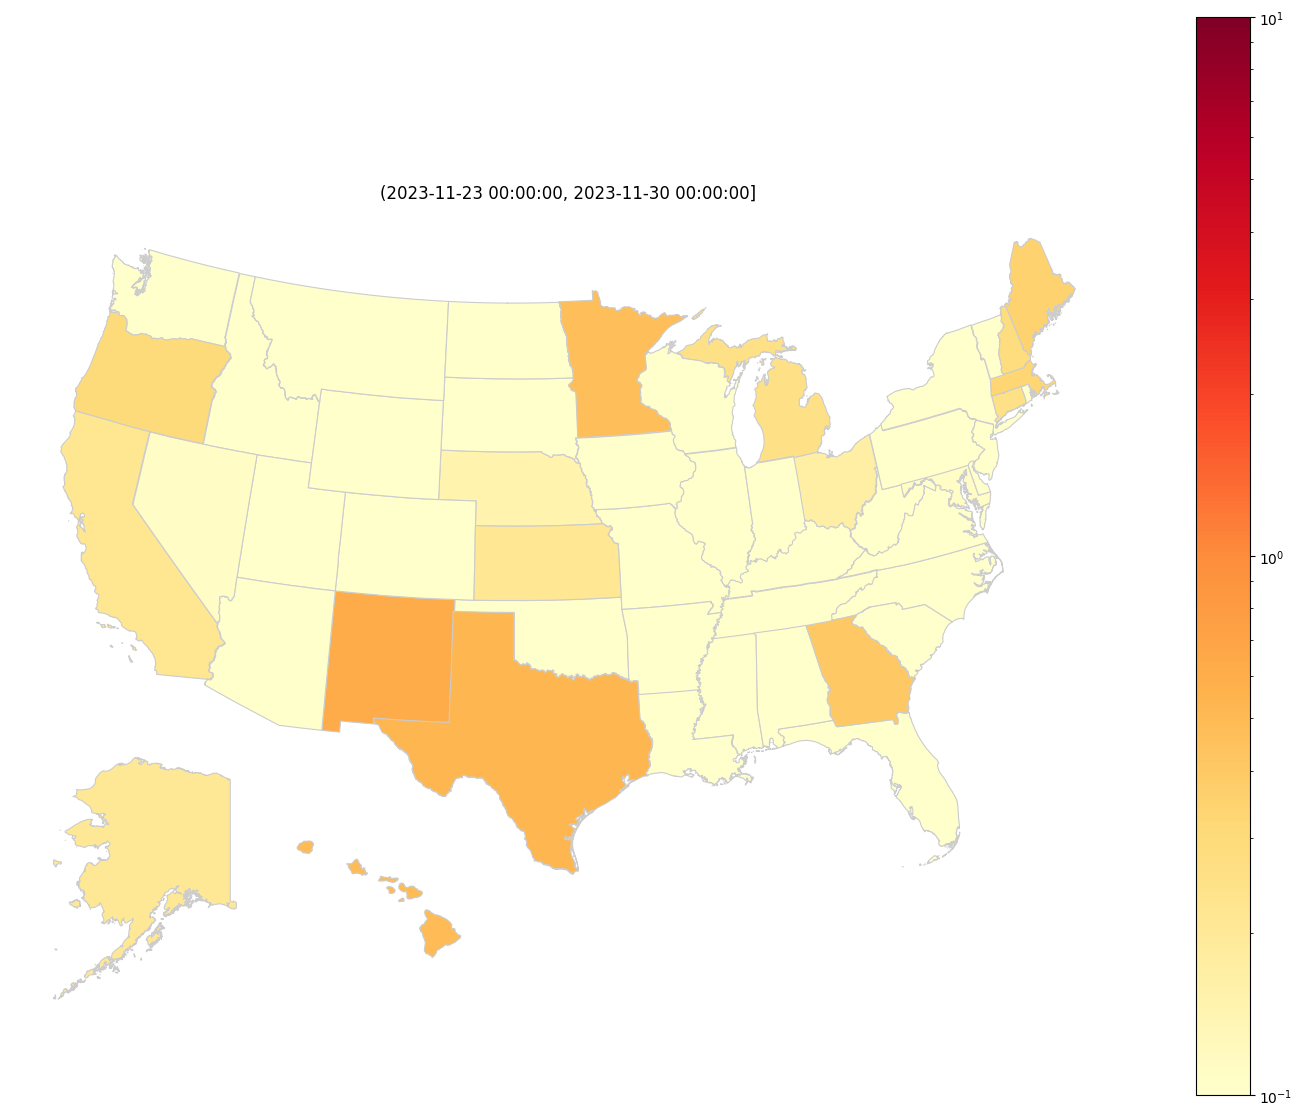

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


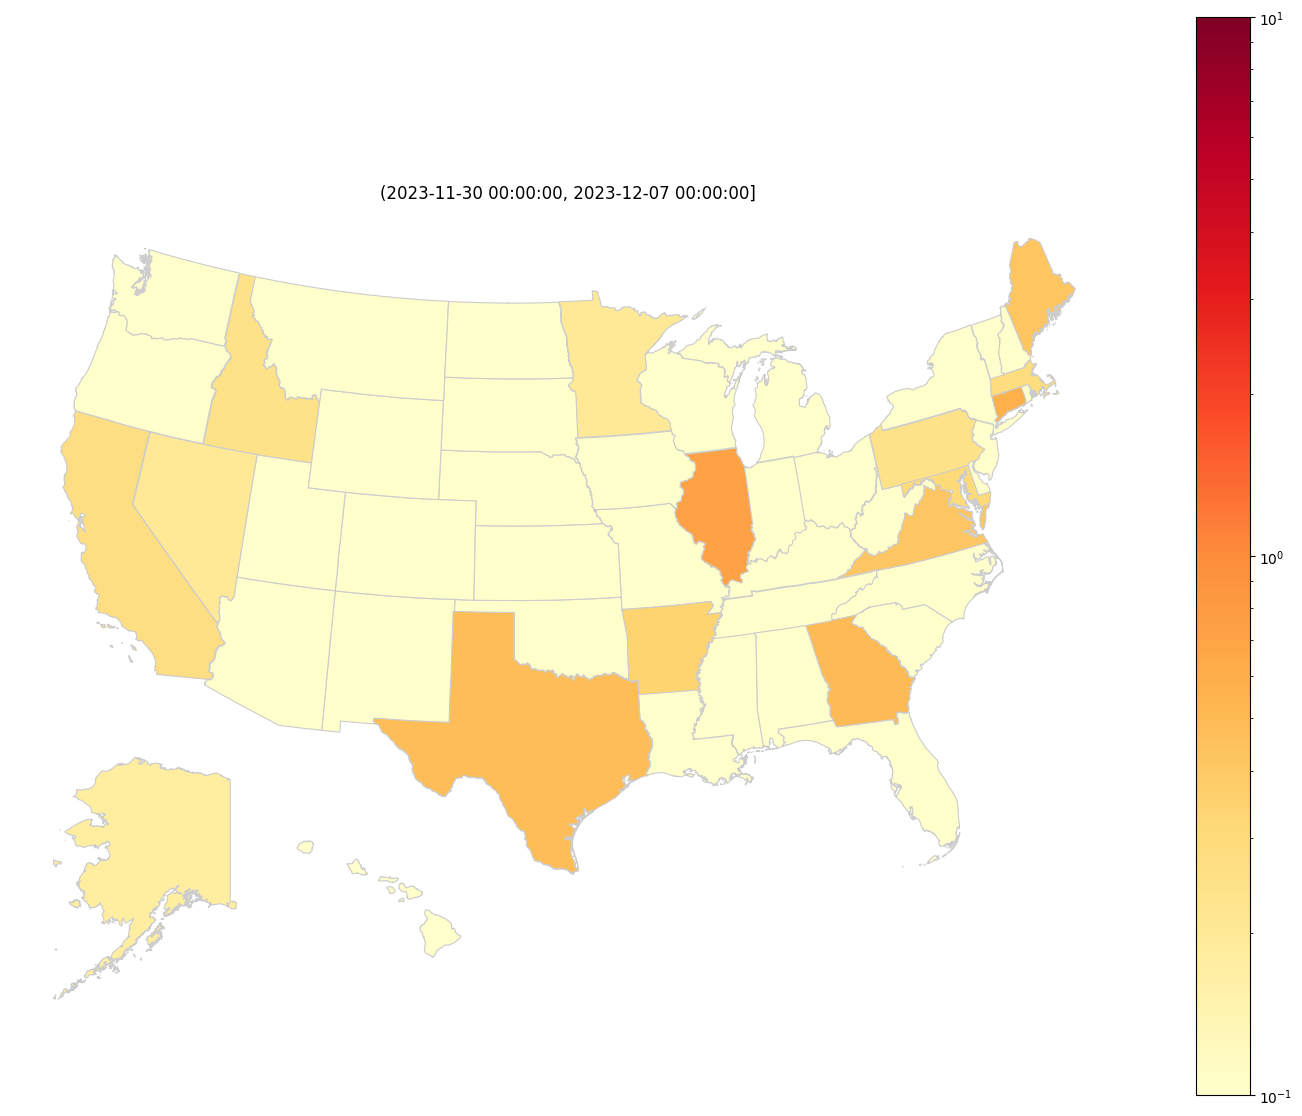

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


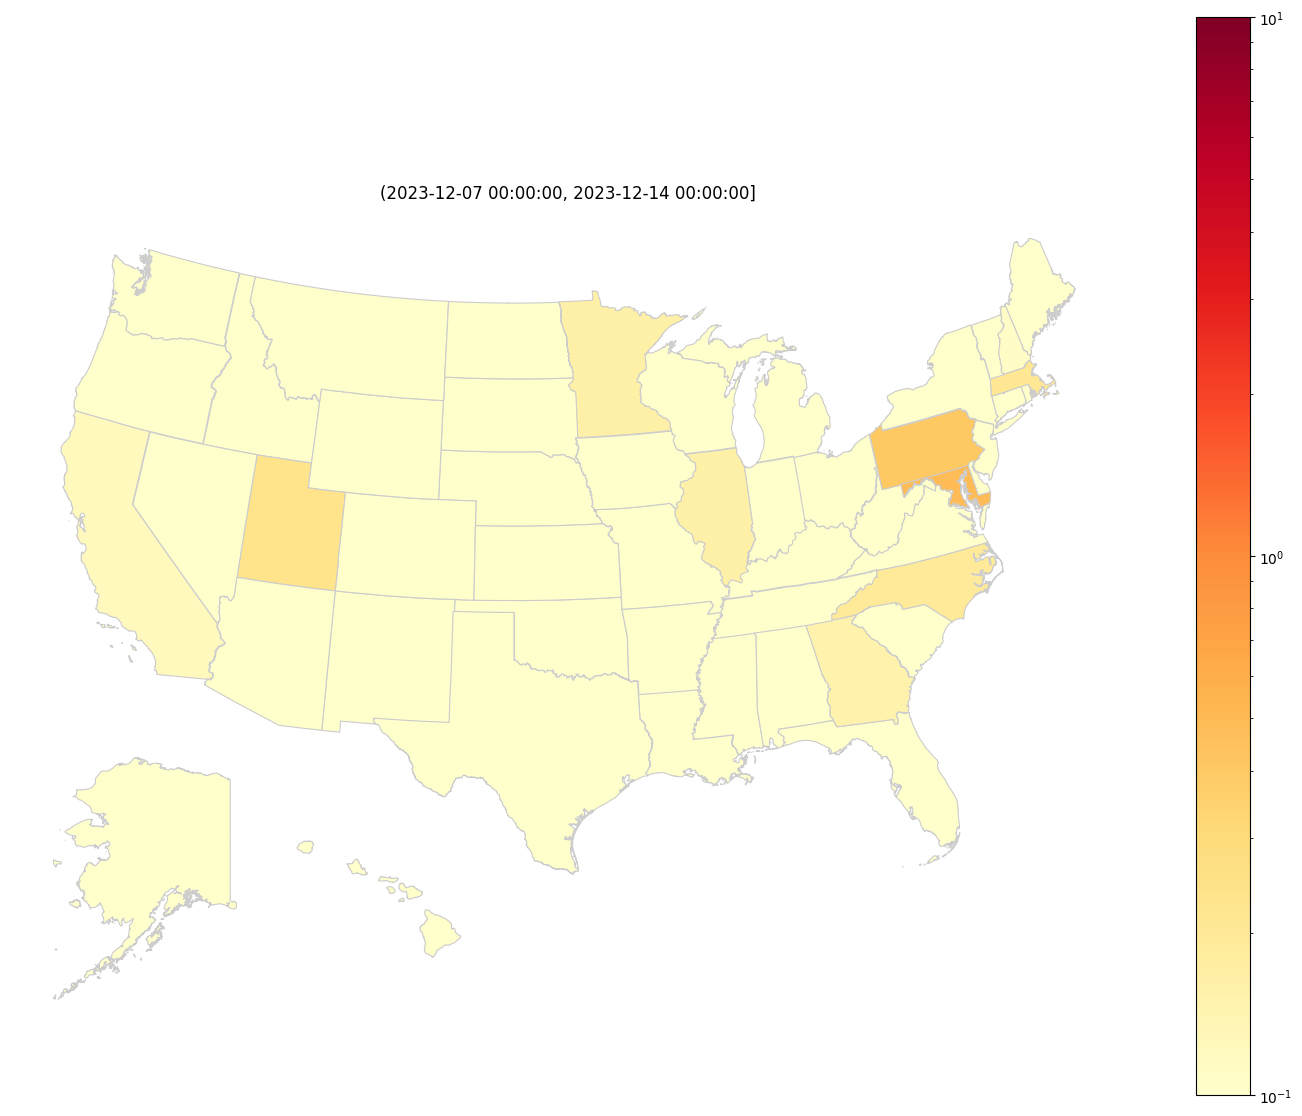

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


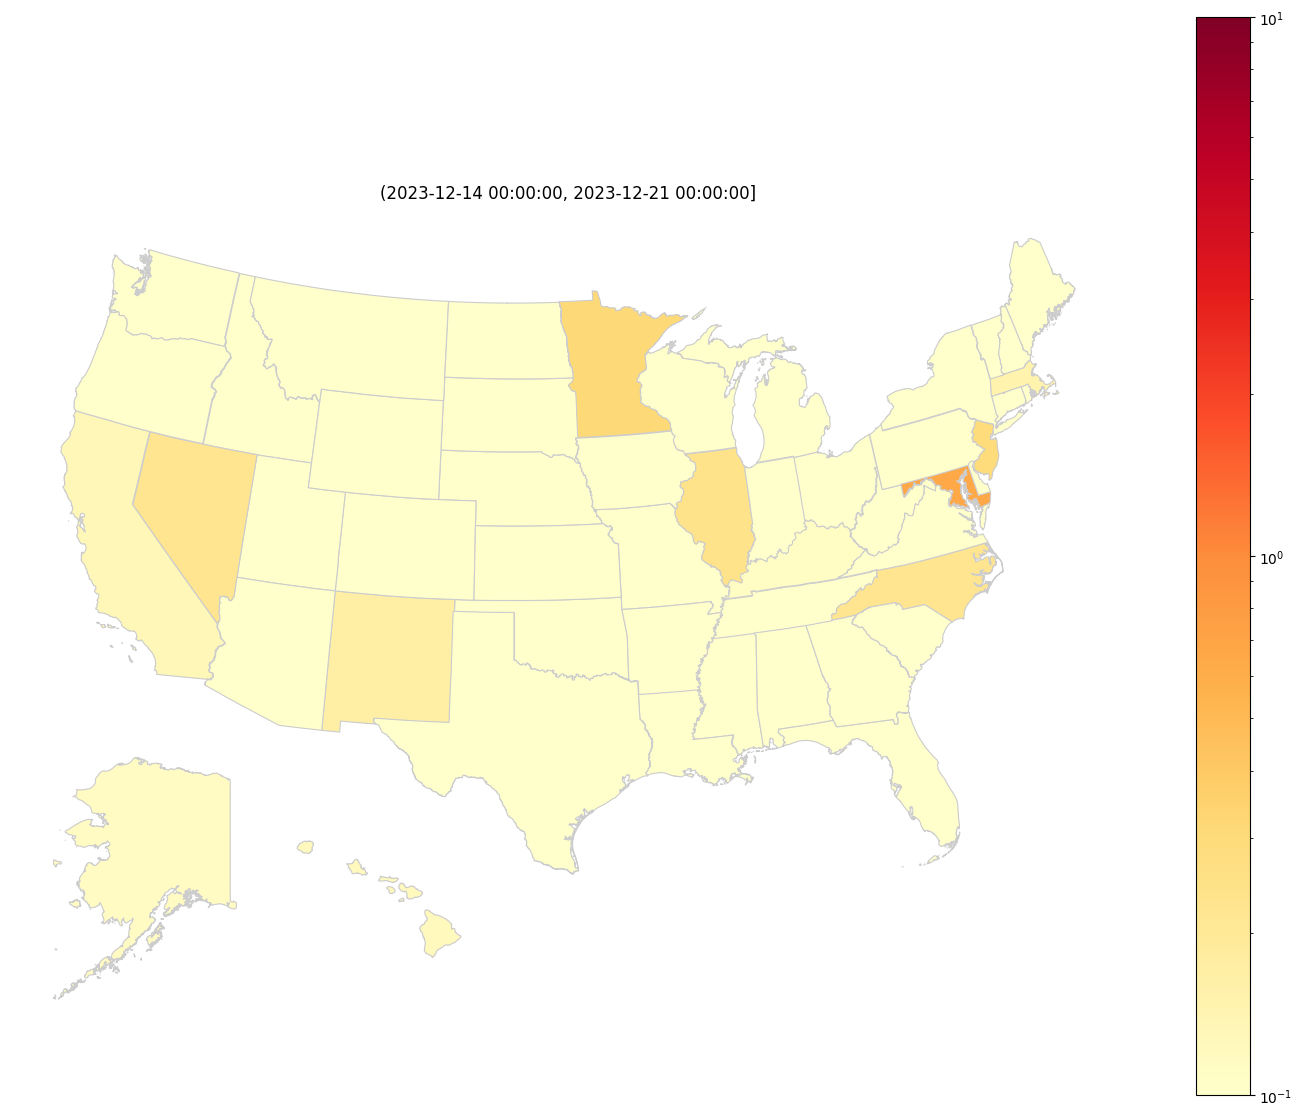

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


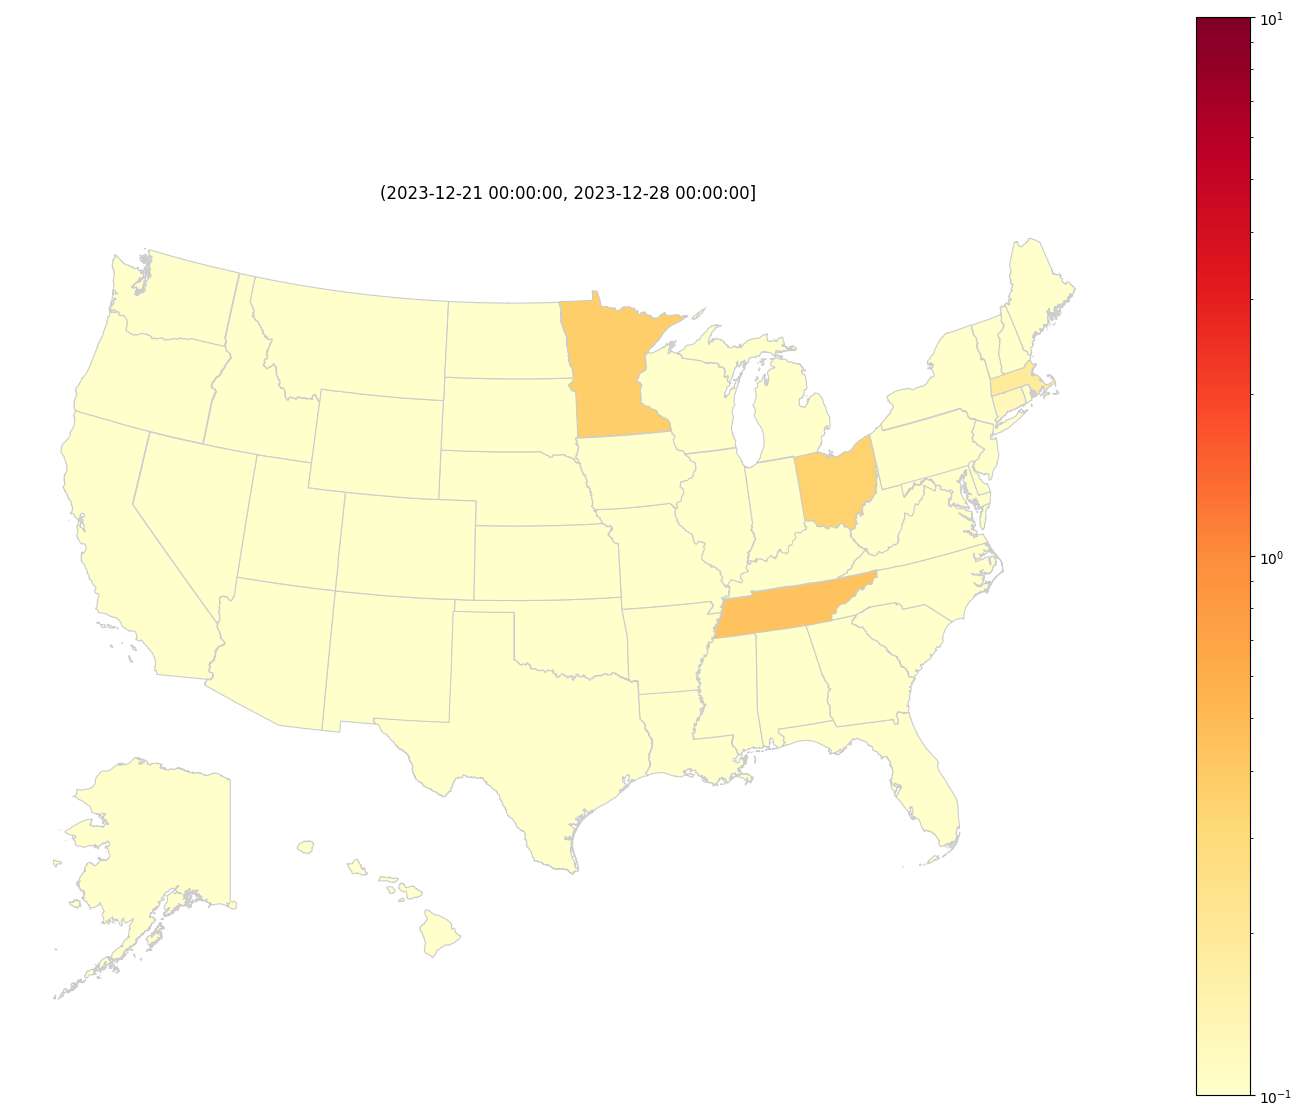

/tmp/ipykernel_746522/684310820.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [21]:
data['STUSPS'] = data['geo_loc_region'].apply(state_to_abbrev)
colors = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.LogNorm(vmin=1e-1, vmax=10, clip=True))
png_list = []
for datebin in np.sort(data['date_bin'].unique()):
    d = data[data['date_bin'] == datebin].set_index('STUSPS')['abundance']
    fig, ax = USmap(d, colors)
    fig.colorbar(colors, ax=ax)
    ax.set_title(datebin)
    plt.show()
    filename = f'map_frames/{lin}_map_wastewater_{datebin}.png'
    fig.savefig(filename)
    png_list.append(filename)

with imageio.get_writer(f'map_gifs/{lin}_ww_map.gif', mode='I', fps=2, loop=False) as writer:
    for filename in png_list:
        image = imageio.imread(filename)
        writer.append_data(image)